Поиск блюда по названию

Разбор блюда на ингридиенты

Запись ингридиентов в excel таблицу (колонки Название, Белки, Жиры, Углеводы, ккал)

Подвод промежуточных итогов

Отображение целой таблицы питания

? Поиск голосом

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import re
import telebot
from telebot import types

In [7]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import re
import telebot
from telebot import types


GOOD_RESPONSE_STATUS = 200


class DishSplitter:
    
    def __init__(
        self,
        yandex_translate_key,
        usda_key, 
        rel_url,
        mass
    ):
        try:
            self.table = self._parse_dish(
                yandex_translate_key, 
                usda_key,
                rel_url, 
                mass
            )
        except Exception as e:
            raise e
        
        
    @staticmethod
    def from_config(
        json_path: str,
        rel_url: str,
        mass: int
    ):
        # загрузка API ключей из json файла
        with open(json_path, 'r') as json_file:
            api_keys = json.load(json_file)

        yandex_translate_key = api_keys['yandex_translate']
        usda_key = api_keys['usda']
        
        # создание объекта класса, который будет использоваться для передачи данных о блюде пользователю
        return DishSplitter(
            yandex_translate_key,
            usda_key,
            rel_url,
            mass / 100
        )
    
    
    def __call__(self) -> pd.DataFrame:
        # возвращает таблицу с поэлементным составом блюда
        return pd.DataFrame(self.table, columns=['Название', 'Масса', 'Белки', 'Жиры', 'Углеводы', 'ккал'])
        
        
    def _parse_dish(self, yandex_translate_key:str, usda_key:str, rel_url:str, mass:int) -> zip:
        
        '''
            По API ключам, относительному адресу блюда на eda.ru и массе 
            возвращает данные (белки, жиры, углеводы, ккал) по каждому из ингридиентов блюда
        '''
        
        # запрос по ранее проверенной ссылке на eda.ru
        recipe_url = f'https://eda.ru{rel_url}'
        
        recipe_response = requests.get(recipe_url, timeout=20)
        recipe_soup = BeautifulSoup(recipe_response.content, 'html.parser')
        
        # получение списка ингридинтов и их количества в блюде
        ingredient_soup = recipe_soup.body.find_all('div', 'ingredients-list__content')[0].p

        labels = []
        amounts = []
        portions = []

        while ingredient_soup is not None:
            ingredient_data = ingredient_soup['data-ingredient-object']
            data_dict = json.loads(ingredient_data)
            labels.append(data_dict['name'])
            amounts.append(data_dict['amount'])
            ingredient_soup = ingredient_soup.next_sibling.next_sibling
            
        # договоримся, что: 
        # один овощь в среднем весит 60 г,
        # в банке 200 г,
        # а "по вкусу" соответствует 5 г
        
        # привидение названий ингридиентов и их массы к удобному для анализа виду
        e = r'[\d%]'
        for i, s in enumerate(labels):
            labels[i] = re.sub(e, '', s).strip()
            
        e1 = r'по вкусу'
        e2 = r'\d* г'
        e3 = r'\d* мл'
        e4 = r'\d* литр.*'
        e5 = r'\d* штук.*'
        e6 = r'\d* чайн.* ложк.*'
        e7 = r'\d* стол.* ложк.*'
        e8 = r'\d* банк.*'
        e9 = r'\d* кус.*'
        
        for i, s in enumerate(amounts):
            if re.match(e1, s):
                res = 5
            elif re.match(e2, s) or re.match(e3, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q)
            elif re.match(e4, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 1000
            elif re.match(e5, s) or re.match(e9, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 60
            elif re.match(e6, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 5
            elif re.match(e7, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 20
            else:
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 200

            amounts[i] = round(res, 2)

        # вычисление количества каждого ингридиента для получения 100 г блюда
        overall_amount = round(sum(amounts), 2)
        amounts = list(map(lambda x: round(x / overall_amount * 100 * mass), amounts))
    
        
        # перевод на английский названий ингридиентов с использованием Yandex Translate API
        # и получение их состава с использование USDA API
        proteins = []
        fats = []
        carbohydrates = []
        kcals = []
        
        translate_url = 'https://translate.api.cloud.yandex.net/translate/v2/translate'
        headers = {'Authorization': f'Api-Key {yandex_translate_key}', 'Content-Type': 'application/json'}

        for i, label in enumerate(labels):
            translate_response = requests.post(translate_url, headers=headers, json={'texts': label, 'targetLanguageCode': 'en'})

            query = translate_response.json()['translations'][0]['text']

            nutrients_url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={query}&pageSize=2&api_key={usda_key}'

            nutrients_response = requests.get(nutrients_url, timeout=20)
            if nutrients_response.status_code != GOOD_RESPONSE_STATUS:
                protein = 0
                fat = 0
                carbohydrate = 0
                kcal = 0
                labels[i] = 'Неизвестный продукт'
            else:
                nutrients_dict = nutrients_response.json()['foods'][0]['foodNutrients']
                protein = round(float(nutrients_dict[0]['value']) * amounts[i] / 100, 2)
                fat = round(float(nutrients_dict[1]['value']) * amounts[i] / 100, 2)
                carbohydrate = round(float(nutrients_dict[2]['value']) * amounts[i] / 100, 2)
                kcal = round(float(nutrients_dict[3]['value']) * amounts[i] / 100, 2)
            proteins.append(protein)
            fats.append(fat)
            carbohydrates.append(carbohydrate)
            kcals.append(kcal)
            
        return zip(labels, amounts, proteins, fats, carbohydrates, kcals)
            


# получение API ключа телеграм бота
json_path = './api_keys.json'

with open(json_path, 'r') as json_file:
    api_keys = json.load(json_file)

TELEBOT_API_KEY = api_keys['telebot']

# инициализация бота
bot = telebot.TeleBot(TELEBOT_API_KEY);

# переменные, нужные для расчета и общения с пользователем
query = ''
mass = 0

first_dish = ''
second_dish = ''
third_dish = ''

first_dish_url = ''
second_dish_url = ''
third_dish_url = ''
relative_url = ''

restart_flag = False


def check_dishname(dish: str) -> bool:
    '''
        Функция проверяет существование рецепта 
        введенного блюда на eda.ru
    '''
    
    url = f'https://eda.ru/recipesearch?q={dish}'
    dish_response = requests.get(url, timeout=20)
    if dish_response.status_code != GOOD_RESPONSE_STATUS:
        print('Bad input')
        return False
    dish_soup = BeautifulSoup(dish_response.content, 'html.parser')
        
    try:
        rel_url = dish_soup.body.find_all('div', 'wrapper-sel')[0]\
            .find_all('section', ['main-content', 'layout__container', 'js-main-content'])[0]\
            .find_all('section', ['recipes-page', '_no-top-pad-search', 'layout__content'])[0]\
            .find_all('div', ['g-relative', 'recipes-page__recipes', 'sticky-content-container'])[0]\
            .find_all('div', ['tile-list', 'layout__content-col', 'widget-list_search', 'js-load-more-content'])[0]\
            .find_all('div', 'clearfix')[0]\
            .div.div['data-href']
    except:
        return False
        
    return True


@bot.message_handler(content_types=['text', 'document'])
def start(message):
    '''
        Стартовое состояние бота
        При вводе пользователем /help выводим подсказку
        При вводе /start начинается общение с пользователем
    '''
    
    if message.text == '/help':
        bot.send_message(message.from_user.id,
                        'Чтобы получить бжу показатели ингредиентов блюда, напишите /start');
    elif message.text == '/start':
        bot.send_message(message.from_user.id, 'Напишите название блюда');
        bot.register_next_step_handler(message, get_dish); 
    else:
        bot.send_message(message.from_user.id, 'Напишите /help');
        
        
def get_dish(message):
    '''
        Функция помогает выбрать пользователю блюдо по названию из доступных
    '''
    
    # введенное пользователем название блюда
    global query
    query = message.text
    
    # проверка на существование введенного блюда
    if not check_dishname(query):
        bot.send_message(message.from_user.id, 'Блюдо не найдено, попробуйте проверить на опечатки и спросить снова')
        bot.register_next_step_handler(message, get_dish)
        return
    
    # посылаем запрос на сайт, чтобы предложить пользователю выбор из 3 блюд
    url = f'https://eda.ru/recipesearch?q={query}'
    menu_response = requests.get(url, timeout=20)
    menu_soup = BeautifulSoup(menu_response.content, 'html.parser')
    
    # получаем первые 3 блюда (их название и относительную ссылку на сайте)
    global first_dish, second_dish, third_dish
    global first_dish_url, second_dish_url, third_dish_url
    
    item = menu_soup.find_all('div', 'tile-list__horizontal-tile horizontal-tile js-portions-count-parent js-bookmark__obj')[0]\
        .find_all('div', 'horizontal-tile__content')[0]
    first_dish = re.sub('\xa0', ' ', item.h3.span.text.strip())
    first_dish_url = item.h3.a['href']
    
    item = menu_soup.find_all('div', 'tile-list__horizontal-tile horizontal-tile js-portions-count-parent js-bookmark__obj')[1]\
        .find_all('div', 'horizontal-tile__content')[0]
    second_dish = re.sub('\xa0', ' ', item.h3.span.text.strip())
    second_dish_url = item.h3.a['href']

    item = menu_soup.find_all('div', 'tile-list__horizontal-tile horizontal-tile js-portions-count-parent js-bookmark__obj')[2]\
        .find_all('div', 'horizontal-tile__content')[0]
    third_dish = re.sub('\xa0', ' ', item.h3.span.text.strip())
    third_dish_url = item.h3.a['href']
    
    # предлагаем пользователю выбрать из 3 опций, нажав на одну из трех кнопок
    keyboard = types.InlineKeyboardMarkup()
    
    key_first_dish = types.InlineKeyboardButton(text=first_dish, callback_data='first')
    keyboard.add(key_first_dish)
    
    key_second_dish = types.InlineKeyboardButton(text=second_dish, callback_data='second')
    keyboard.add(key_second_dish)
    
    key_third_dish = types.InlineKeyboardButton(text=third_dish, callback_data='third')
    keyboard.add(key_third_dish)
    
    key_exit = types.InlineKeyboardButton(text='Попробовать сначала', callback_data='exit')
    keyboard.add(key_exit)

    question = 'Выберите нужное блюдо'
    bot.send_message(message.from_user.id, text=question, reply_markup=keyboard)
    
    # обрабатываем дальнейшее действие получения массы
    global restart_flag
    if not restart_flag:
        bot.register_next_step_handler(message, get_mass)
    restart_flag = False
    


@bot.callback_query_handler(func=lambda call: True)
def callback_worker(call):
    '''
        Функция обработчик события нажатия на кнопку
    '''
    
    global restart_flag
    global query, first_dish, second_dish, third_dish
    global relative_url, first_dish_url, second_dish_url, third_dish_url
    
    if call.data == 'first':
        query = first_dish
        relative_url = first_dish_url
    elif call.data == 'second':
        query = second_dish
        relative_url = second_dish_url
    elif call.data == 'third':
        query = third_dish
        relative_url = third_dish_url
    elif call.data == 'exit':
        bot.send_message(call.message.chat.id, 'Напишите название блюда')
        bot.register_next_step_handler(call.message, get_dish)
        restart_flag = True
        return
    else:
        bot.send_message(call.message.chat.id, 'Что-то пошло не так, попробуйте еще раз')
        bot.register_next_step_handler(call.message, get_dish)
        restart_flag = True
        return
    
    # дальнейшее взаимодействие с пользователем
    bot.send_message(call.message.chat.id, 'Напишите массу в граммах')
        
    
def get_mass(message): 
    '''
        Функция получает массу и выдает пользователю результат в виде excel таблицы
    '''
    
    # получение массы от пользователя
    global restart_flag
    if restart_flag: return
    global mass
    try:
        mass = float(message.text)
    except Exception:
        bot.send_message(message.from_user.id, 'Цифрами, пожалуйста')
        bot.register_next_step_handler(message, get_mass)
        return

    # инициализация объекта класса 
    bot.send_message(message.from_user.id, 'Начинаю расчеты...')
    global relative_url
    try:
        dish_splitter = DishSplitter.from_config(
            json_path='./api_keys.json',
            rel_url=relative_url,
            mass=mass
        )
    except:
        bot.send_message(message.from_user.id, 'Что-то пошло не так на стороне сервиса. Попробуйте начать сначала')
        bot.register_next_step_handler(message, get_dish)
        return
        
    # работа с таблицей
    df = dish_splitter()
    ds = pd.Series({
        'Название': 'Итог',
        'Масса': mass,
        'Белки': round(df['Белки'].sum(), 2),
        'Жиры': round(df['Жиры'].sum(), 2),
        'Углеводы': round(df['Углеводы'].sum(), 2),
        'ккал': round(df['ккал'].sum(), 2),
    })
    df = df.append(pd.Series(), ignore_index=True).append(ds, ignore_index=True)
    df.to_excel(f'{query}.xlsx', index=False)
    
    # отправка результата пользователю
    bot.send_message(message.from_user.id, 'Расчеты закончены, высылаю таблицу')
    with open(f'{query}.xlsx', 'rb') as file:
        bot.send_document(message.from_user.id, file)
    
    # ожидание следующего названия блюда
    mass = 0
    bot.send_message(message.from_user.id, 'Напишите название слюдующего блюда')
    bot.register_next_step_handler(message, get_dish)
        
        
bot.polling(none_stop=True, interval=0)

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import re
import telebot
from telebot import types


GOOD_RESPONSE_STATUS = 200


class DishSplitter:
    
    def __init__(
        self,
        yandex_translate_key,
        usda_key, 
        rel_url,
        mass
    ):
        try:
            self.table = self._parse_dish(
                yandex_translate_key, 
                usda_key,
                rel_url, 
                mass
            )
        except Exception as e:
            raise e
        
        
    @staticmethod
    def from_config(
        json_path: str,
        rel_url: str,
        mass: int
    ):
        with open(json_path, 'r') as json_file:
            api_keys = json.load(json_file)

        yandex_translate_key = api_keys['yandex_translate']
        usda_key = api_keys['usda']
        
        return DishSplitter(
            yandex_translate_key,
            usda_key,
            rel_url,
            mass / 100
        )
    
    
    def __call__(self) -> pd.DataFrame:
        return pd.DataFrame(self.table, columns=['Название', 'Масса', 'Белки', 'Жиры', 'Углеводы', 'ккал'])
        
        
    def _parse_dish(self, yandex_translate_key:str, usda_key:str, rel_url:str, mass:int) -> zip:
#         url = f'https://eda.ru/recipesearch?q={dish}'
#         try:
#             dish_response = requests.get(url, timeout=20)
#         except Exception as e:
#             raise e
#         dish_soup = BeautifulSoup(dish_response.content, 'html.parser')
        
#         rel_url = dish_soup.body.find_all('div', 'wrapper-sel')[0]\
#             .find_all('section', ['main-content', 'layout__container', 'js-main-content'])[0]\
#             .find_all('section', ['recipes-page', '_no-top-pad-search', 'layout__content'])[0]\
#             .find_all('div', ['g-relative', 'recipes-page__recipes', 'sticky-content-container'])[0]\
#             .find_all('div', ['tile-list', 'layout__content-col', 'widget-list_search', 'js-load-more-content'])[0]\
#             .find_all('div', 'clearfix')[0]\
#             .div.div['data-href']
        
        recipe_url = f'https://eda.ru{rel_url}'
        
        recipe_response = requests.get(recipe_url, timeout=20)
        recipe_soup = BeautifulSoup(recipe_response.content, 'html.parser')
        
        ingredient_soup = recipe_soup.body.find_all('div', 'ingredients-list__content')[0].p

        labels = []
        amounts = []
        portions = []

        while ingredient_soup is not None:
            ingredient_data = ingredient_soup['data-ingredient-object']
            data_dict = json.loads(ingredient_data)
            labels.append(data_dict['name'])
            amounts.append(data_dict['amount'])
            ingredient_soup = ingredient_soup.next_sibling.next_sibling
            
        # Договоримся, что один овощь в среднем весит 60 г, в банке 200 г, а "по вкусу" соответствует 5 г
        
        e = r'[\d%]'
        for i, s in enumerate(labels):
            labels[i] = re.sub(e, '', s).strip()
            
        e1 = r'по вкусу'
        e2 = r'\d* г'
        e3 = r'\d* мл'
        e4 = r'\d* литр.*'
        e5 = r'\d* штук.*'
        e6 = r'\d* чайн.* ложк.*'
        e7 = r'\d* стол.* ложк.*'
        e8 = r'\d* банк.*'
        e9 = r'\d* кус.*'
        
        for i, s in enumerate(amounts):
            if re.match(e1, s):
                res = 5
            elif re.match(e2, s) or re.match(e3, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q)
            elif re.match(e4, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 1000
            elif re.match(e5, s) or re.match(e9, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 60
            elif re.match(e6, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 5
            elif re.match(e7, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 20
            else:
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 200

            amounts[i] = round(res, 2)

        overall_amount = round(sum(amounts), 2)

        amounts = list(map(lambda x: round(x / overall_amount * 100 * mass), amounts))
    
        
        proteins = []
        fats = []
        carbohydrates = []
        kcals = []
        
        translate_url = 'https://translate.api.cloud.yandex.net/translate/v2/translate'
        headers = {'Authorization': f'Api-Key {yandex_translate_key}', 'Content-Type': 'application/json'}

        for i, label in enumerate(labels):
            translate_response = requests.post(translate_url, headers=headers, json={'texts': label, 'targetLanguageCode': 'en'})

            query = translate_response.json()['translations'][0]['text']

            nutrients_url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={query}&pageSize=2&api_key={usda_key}'

            nutrients_response = requests.get(nutrients_url, timeout=20)
            if nutrients_response.status_code != GOOD_RESPONSE_STATUS:
                protein = 0
                fat = 0
                carbohydrate = 0
                kcal = 0
                labels[i] = 'Неизвестный продукт'
            else:
                nutrients_dict = nutrients_response.json()['foods'][0]['foodNutrients']
                protein = round(float(nutrients_dict[0]['value']) * amounts[i] / 100, 2)
                fat = round(float(nutrients_dict[1]['value']) * amounts[i] / 100, 2)
                carbohydrate = round(float(nutrients_dict[2]['value']) * amounts[i] / 100, 2)
                kcal = round(float(nutrients_dict[3]['value']) * amounts[i] / 100, 2)
            proteins.append(protein)
            fats.append(fat)
            carbohydrates.append(carbohydrate)
            kcals.append(kcal)
            
        return zip(labels, amounts, proteins, fats, carbohydrates, kcals)
            

        
json_path = './api_keys.json'

with open(json_path, 'r') as json_file:
    api_keys = json.load(json_file)

TELEBOT_API_KEY = api_keys['telebot']

bot = telebot.TeleBot(TELEBOT_API_KEY);

query = ''
mass = 0

first_dish = ''
second_dish = ''
third_dish = ''


def check_dishname(dish: str) -> bool:
    url = f'https://eda.ru/recipesearch?q={dish}'
    dish_response = requests.get(url, timeout=20)
    if dish_response.status_code != GOOD_RESPONSE_STATUS:
        print('Bad input')
        return False
    dish_soup = BeautifulSoup(dish_response.content, 'html.parser')
        
    try:
        rel_url = dish_soup.body.find_all('div', 'wrapper-sel')[0]\
            .find_all('section', ['main-content', 'layout__container', 'js-main-content'])[0]\
            .find_all('section', ['recipes-page', '_no-top-pad-search', 'layout__content'])[0]\
            .find_all('div', ['g-relative', 'recipes-page__recipes', 'sticky-content-container'])[0]\
            .find_all('div', ['tile-list', 'layout__content-col', 'widget-list_search', 'js-load-more-content'])[0]\
            .find_all('div', 'clearfix')[0]\
            .div.div['data-href']
    except:
        return False
        
    return True


@bot.message_handler(content_types=['text', 'document'])
def start(message):
    if message.text == '/help':
        bot.send_message(message.from_user.id,
                        'Чтобы получить бжу показатели ингредиентов блюда, напиши /start');
    elif message.text == '/start':
        bot.send_message(message.from_user.id, 'Напиши название блюда');
        bot.register_next_step_handler(message, get_dish); 
    else:
        bot.send_message(message.from_user.id, 'Напиши /help');
        
        
def get_dish(message):
    global query
    query = message.text
    
    if not check_dishname(query):
        bot.send_message(message.from_user.id, 'Блюдо не найдено, попробуй проверить на опечатки и спросить снова')
        bot.register_next_step_handler(message, get_dish)
        return
    
    url = f'https://eda.ru/recipesearch?q={query}'
    menu_response = requests.get(url, timeout=20)
    menu_soup = BeautifulSoup(menu_response.content, 'html.parser')
    
    # взять первые 3 блюда
    global first_dish, second_dish, third_dish
    
    item = menu_soup.find_all('div', 'tile-list__horizontal-tile horizontal-tile js-portions-count-parent js-bookmark__obj')[0]\
        .find_all('div', 'horizontal-tile__content')[0]
    first_dish = re.sub('\xa0', ' ', item.h3.span.text.strip())
    first_dish_url = item.h3.a['href']
    
    item = menu_soup.find_all('div', 'tile-list__horizontal-tile horizontal-tile js-portions-count-parent js-bookmark__obj')[1]\
        .find_all('div', 'horizontal-tile__content')[0]
    second_dish = re.sub('\xa0', ' ', item.h3.span.text.strip())
    second_dish_url = item.h3.a['href']

    item = menu_soup.find_all('div', 'tile-list__horizontal-tile horizontal-tile js-portions-count-parent js-bookmark__obj')[2]\
        .find_all('div', 'horizontal-tile__content')[0]
    third_dish = re.sub('\xa0', ' ', item.h3.span.text.strip())
    third_dish_link = item.h3.a['href']
    
    keyboard = types.InlineKeyboardMarkup()
    
    key_first_dish = types.InlineKeyboardButton(text=first_dish, callback_data='first')
    keyboard.add(key_first_dish)
    
    key_second_dish = types.InlineKeyboardButton(text=second_dish, callback_data='second')
    keyboard.add(key_second_dish)
    
    key_third_dish = types.InlineKeyboardButton(text=third_dish, callback_data='third')
    keyboard.add(key_third_dish)
    
    key_exit = types.InlineKeyboardButton(text='Попробовать сначала', callback_data='exit')
    keyboard.add(key_exit)

    question = 'Выбери нужное блюдо'
    bot.send_message(message.from_user.id, text=question, reply_markup=keyboard)
    
    # bot.send_message(message.from_user.id, 'Напиши массу в граммах')
    bot.register_next_step_handler(message, get_mass)
    


@bot.callback_query_handler(func=lambda call: True)
def callback_worker(call):
    global query, first_dish, second_dish, third_dish
    global relative_url, first_dish_url, second_dish_url, third_dish_url
    
    if call.data == 'first':
        query = first_dish
        relative_url = first_dish_url
    elif call.data == 'second':
        query = second_dish
        relative_url = second_dish_url
    elif call.data == 'third':
        query = third_dish
        relative_url = third_dish_url
    elif call.data == 'exit':
        bot.send_message(call.message.chat.id, 'Напиши название блюда')
        bot.register_next_step_handler(call.message, get_dish)
        return
    else:
        bot.send_message(call.message.chat.id, 'Что-то пошло не так, попробуй еще раз')
        bot.register_next_step_handler(call.message, get_dish)
        return
    
    bot.send_message(call.message.chat.id, 'Напиши массу в граммах')
    
        
    
def get_mass(message): 
    global mass
    
    while mass == 0:
        try:
             mass = float(message.text)
        except Exception:
             bot.send_message(message.from_user.id, 'Цифрами, пожалуйста');

    bot.send_message(message.from_user.id, 'Начинаю расчеты...')
    
    global relative_url
    
    try:
        dish_splitter = DishSplitter.from_config(
            json_path='./api_keys.json',
            rel_url=relative_url,
            mass=mass
        )
    except:
        bot.send_message(message.from_user.id, 'Что-то пошло не так. Попробуй начать сначала')
        bot.register_next_step_handler(message, get_dish)
        return
        
    df = dish_splitter()
    ds = pd.Series({
        'Название': 'Итог',
        'Масса': mass,
        'Белки': round(df['Белки'].sum(), 2),
        'Жиры': round(df['Жиры'].sum(), 2),
        'Углеводы': round(df['Углеводы'].sum(), 2),
        'ккал': round(df['ккал'].sum(), 2),
    })
    df = df.append(pd.Series(), ignore_index=True).append(ds, ignore_index=True)
    df.to_excel(f'{query}.xlsx', index=False)
    
    bot.send_message(message.from_user.id, 'Расчеты закончены, держи таблицу')
    with open(f'{query}.xlsx', 'rb') as file:
        bot.send_document(message.from_user.id, file)
    
    mass = 0
    bot.register_next_step_handler(message, get_dish)
        
        
bot.polling(none_stop=True, interval=0)

In [38]:
q = 'салат цезарь'
url = f'https://eda.ru/recipesearch?q={q}'
menu_response = requests.get(url, timeout=20)
menu_soup = BeautifulSoup(menu_response.content, 'html.parser')
    
menu_soup.find_all('div', 'tile-list__horizontal-tile horizontal-tile js-portions-count-parent js-bookmark__obj')[1]\
        .find_all('div', 'horizontal-tile__content')[0]

re.sub('\xa0', ' ', item.h3.span.text.strip())

# item.h3.a['href']

'Салат «Цезарь» с чесночным майонезом'

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import re
import telebot

GOOD_RESPONSE_STATUS = 200

class DishSplitter:
    
    def __init__(
        self,
        yandex_translate_key,
        usda_key, 
        dish,
        mass
    ):
        try:
            self.table = self._parse_dish(
                yandex_translate_key, 
                usda_key,
                dish, 
                mass
            )
        except Exception as e:
            raise e
        
    @staticmethod
    def from_config(
        json_path: str,
        dish: str,
        mass: int
    ):
        with open(json_path, 'r') as json_file:
            api_keys = json.load(json_file)

        yandex_translate_key = api_keys['yandex_translate']
        usda_key = api_keys['usda']
        
        return DishSplitter(
            yandex_translate_key,
            usda_key,
            dish.strip(),
            mass / 100
        )
    
    def __call__(self) -> pd.DataFrame:
        return pd.DataFrame(self.table, columns=['Название', 'Масса', 'Белки', 'Жиры', 'Углеводы', 'ккал'])
        
    def _parse_dish(self, yandex_translate_key:str, usda_key:str, dish:str, mass:int) -> zip:
        url = f'https://eda.ru/recipesearch?q={dish}'
        try:
            dish_response = requests.get(url, timeout=20)
        except Exception as e:
            raise e
        dish_soup = BeautifulSoup(dish_response.content, 'html.parser')
        
        rel_url = dish_soup.body.find_all('div', 'wrapper-sel')[0]\
            .find_all('section', ['main-content', 'layout__container', 'js-main-content'])[0]\
            .find_all('section', ['recipes-page', '_no-top-pad-search', 'layout__content'])[0]\
            .find_all('div', ['g-relative', 'recipes-page__recipes', 'sticky-content-container'])[0]\
            .find_all('div', ['tile-list', 'layout__content-col', 'widget-list_search', 'js-load-more-content'])[0]\
            .find_all('div', 'clearfix')[0]\
            .div.div['data-href']
        
        recipe_url = f'https://eda.ru{rel_url}'
        
        recipe_response = requests.get(recipe_url, timeout=20)
        recipe_soup = BeautifulSoup(recipe_response.content, 'html.parser')
        
        ingredient_soup = recipe_soup.body.find_all('div', 'ingredients-list__content')[0].p

        labels = []
        amounts = []
        portions = []

        while ingredient_soup is not None:
            ingredient_data = ingredient_soup['data-ingredient-object']
            data_dict = json.loads(ingredient_data)
            labels.append(data_dict['name'])
            amounts.append(data_dict['amount'])
            ingredient_soup = ingredient_soup.next_sibling.next_sibling
            
        # Договоримся, что один овощь в среднем весит 60 г, в банке 200 г, а "по вкусу" соответствует 5 г
        
        e = r'[\d%]'
        for i, s in enumerate(labels):
            labels[i] = re.sub(e, '', s).strip()
            
        e1 = r'по вкусу'
        e2 = r'\d* г'
        e3 = r'\d* мл'
        e4 = r'\d* литр.*'
        e5 = r'\d* штук.*'
        e6 = r'\d* чайн.* ложк.*'
        e7 = r'\d* стол.* ложк.*'
        e8 = r'\d* банк.*'
        e9 = r'\d* кус.*'
        
        for i, s in enumerate(amounts):
            if re.match(e1, s):
                res = 5
            elif re.match(e2, s) or re.match(e3, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q)
            elif re.match(e4, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 1000
            elif re.match(e5, s) or re.match(e9, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 60
            elif re.match(e6, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 5
            elif re.match(e7, s):
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 20
            else:
                q = re.sub(',', '.', re.findall(r'\d*', s)[0])
                if q == '':
                    q = 0.5
                res = float(q) * 200

            amounts[i] = round(res, 2)

        overall_amount = round(sum(amounts), 2)

        amounts = list(map(lambda x: round(x / overall_amount * 100 * mass), amounts))
    
        
        proteins = []
        fats = []
        carbohydrates = []
        kcals = []
        
        translate_url = 'https://translate.api.cloud.yandex.net/translate/v2/translate'
        headers = {'Authorization': f'Api-Key {yandex_translate_key}', 'Content-Type': 'application/json'}

        for i, label in enumerate(labels):
            translate_response = requests.post(translate_url, headers=headers, json={'texts': label, 'targetLanguageCode': 'en'})

            query = translate_response.json()['translations'][0]['text']

            nutrients_url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={query}&pageSize=2&api_key={usda_key}'

            nutrients_response = requests.get(nutrients_url, timeout=20)
            if nutrients_response.status_code != GOOD_RESPONSE_STATUS:
                protein = 0
                fat = 0
                carbohydrate = 0
                kcal = 0
                labels[i] = 'Неизвестный продукт'
            else:
                nutrients_dict = nutrients_response.json()['foods'][0]['foodNutrients']
                protein = round(float(nutrients_dict[0]['value']) * amounts[i] / 100, 2)
                fat = round(float(nutrients_dict[1]['value']) * amounts[i] / 100, 2)
                carbohydrate = round(float(nutrients_dict[2]['value']) * amounts[i] / 100, 2)
                kcal = round(float(nutrients_dict[3]['value']) * amounts[i] / 100, 2)
            proteins.append(protein)
            fats.append(fat)
            carbohydrates.append(carbohydrate)
            kcals.append(kcal)
            
        return zip(labels, amounts, proteins, fats, carbohydrates, kcals)
            

json_path = './api_keys.json'

with open(json_path, 'r') as json_file:
    api_keys = json.load(json_file)

TELEBOT_API_KEY = api_keys['telebot']

bot = telebot.TeleBot(TELEBOT_API_KEY);

query = ''
mass = 0


def check_dishname(dish: str) -> bool:
    url = f'https://eda.ru/recipesearch?q={dish}'
    dish_response = requests.get(url, timeout=20)
    if dish_response.status_code != GOOD_RESPONSE_STATUS:
        print('Bad input')
        return False
    dish_soup = BeautifulSoup(dish_response.content, 'html.parser')
        
    try:
        rel_url = dish_soup.body.find_all('div', 'wrapper-sel')[0]\
            .find_all('section', ['main-content', 'layout__container', 'js-main-content'])[0]\
            .find_all('section', ['recipes-page', '_no-top-pad-search', 'layout__content'])[0]\
            .find_all('div', ['g-relative', 'recipes-page__recipes', 'sticky-content-container'])[0]\
            .find_all('div', ['tile-list', 'layout__content-col', 'widget-list_search', 'js-load-more-content'])[0]\
            .find_all('div', 'clearfix')[0]\
            .div.div['data-href']
    except:
        return False
        
    return True

@bot.message_handler(content_types=['text', 'document'])
def start(message):
    if message.text == '/help':
        bot.send_message(message.from_user.id,
                        'Чтобы получить бжу показатели ингредиентов блюда, напиши /start');
    elif message.text == '/start':
        bot.send_message(message.from_user.id, 'Напиши название блюда');
        bot.register_next_step_handler(message, get_dish); 
    else:
        bot.send_message(message.from_user.id, 'Напиши /help');
        
def get_dish(message):
    global query
    query = message.text
    
    if not check_dishname(query):
        bot.send_message(message.from_user.id, 'Блюдо не найдено, попробуй проверить на опечатки и спросить снова')
        bot.register_next_step_handler(message, get_dish)
        return
    
    bot.send_message(message.from_user.id, 'Напиши массу в граммах')
    bot.register_next_step_handler(message, get_mass)

    
def get_mass(message):
    global mass
    
    while mass == 0:
        try:
             mass = float(message.text)
        except Exception:
             bot.send_message(message.from_user.id, 'Цифрами, пожалуйста');

    bot.send_message(message.from_user.id, 'Начинаю расчеты...')
    
    try:
        dish_splitter = DishSplitter.from_config(
            json_path='./api_keys.json',
            dish=query,
            mass=mass
        )
    except:
        bot.send_message(message.from_user.id, 'Что-то пошло не так. Попробуй начать сначала')
        bot.register_next_step_handler(message, get_dish)
        return
        
    df = dish_splitter()
    ds = pd.Series({
        'Название': 'Итог',
        'Масса': mass,
        'Белки': round(df['Белки'].sum(), 2),
        'Жиры': round(df['Жиры'].sum(), 2),
        'Углеводы': round(df['Углеводы'].sum(), 2),
        'ккал': round(df['ккал'].sum(), 2),
    })
    df = df.append(pd.Series(), ignore_index=True).append(ds, ignore_index=True)
    df.to_excel(f'{query}.xlsx', index=False)
    
    bot.send_message(message.from_user.id, 'Расчеты закончены, держи таблицу')
    with open(f'{query}.xlsx', 'rb') as file:
        bot.send_document(message.from_user.id, file)
        
        
bot.polling(none_stop=True, interval=0)

In [215]:
dish_splitter = DishSplitter.from_config(
    json_path='./api_keys.json',
    dish='винегрет',
    mass=300
)

Fail


UnboundLocalError: local variable 'dish_response' referenced before assignment

In [ ]:
dish_splitter()

In [7]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import re
import telebot
from telebot import types

In [10]:
GOOD_RESPONSE_STATUS = 200

In [14]:
tip = 'блины'
mass = 3 # 300 g
url = f'https://eda.ru/recipesearch?q={tip}'

In [15]:
try:
    response = requests.get(url, timeout=20)
except:
    print('Fail')
if response.status_code != GOOD_RESPONSE_STATUS:
    print('Something went wrong')

In [16]:
soup = BeautifulSoup(response.content, 'html.parser')

In [20]:
rel_link = soup.find_all('div', {'class': 'horizontal-tile__content'})[0].h3.a['href']

In [21]:
# rel_link = soup.body.find_all('div', 'wrapper-sel')[0]\
#         .find_all('section', ['main-content', 'layout__container', 'js-main-content'])[0]\
#         .find_all('section', ['recipes-page', '_no-top-pad-search', 'layout__content'])[0]\
#         .find_all('div', ['g-relative', 'recipes-page__recipes', 'sticky-content-container'])[0]\
#         .find_all('div', ['tile-list', 'layout__content-col', 'widget-list_search', 'js-load-more-content'])[0]\
#         .find_all('div', 'clearfix')[0]\
#         .div.div['data-href']

In [22]:
recipe_url = f'https://eda.ru{rel_link}'

In [23]:
try:
    recipe_response = requests.get(recipe_url, timeout=20)
except:
    print('Fail')
if recipe_response.status_code != GOOD_RESPONSE_STATUS:
    print('Could not find recipe')

In [24]:
recipe_soup = BeautifulSoup(recipe_response.content, 'html.parser')

In [43]:
recipe_soup.main.div.div.div.span.div.

<div class="css-qdbi44"><div class="css-196vidb"><img alt="Американские блины" class="lazy" data-src="https://s1.eda.ru/StaticContent/Photos/120131085624/171210104827/p_O.jpg"/></div><div class="css-mpp3lf"><div class="css-1l38tu6-composedStyles"><div class="css-1iviqcf-Column"><div class="css-a90bfp" itemscope="" itemtype="http://schema.org/BreadcrumbList"><span itemprop="itemListElement" itemscope="" itemtype="http://schema.org/ListItem"><a href="https://eda.ru/recepty/zavtraki" itemprop="url"><span class="css-rit9g1-Info" title="">Завтраки</span><span class="css-m6xfq2-Info" title=""></span></a><meta content="Завтраки" itemprop="name"/><meta content="1" itemprop="position"/><meta content="https://eda.ru/recepty/zavtraki" itemprop="item"/></span><span itemprop="itemListElement" itemscope="" itemtype="http://schema.org/ListItem"><a href="https://eda.ru/recepty/amerikanskaya-kuhnya" itemprop="url"><span class="css-rit9g1-Info" title="">Американская кухня</span><span class="css-m6xfq2-I

In [27]:
recipe_soup.find_all('div', 'ingredients-list__content')

[]

In [25]:
ingredient_soup = recipe_soup.body.find_all('div', 'ingredients-list__content')[0].p

labels = []
amounts = []
portions = []

while ingredient_soup is not None:
    parts = int(recipe_soup.body.find_all('div', 'portions-control')[0].input['value'])
    ingredient_data = ingredient_soup['data-ingredient-object']
    data_dict = json.loads(ingredient_data)
    labels.append(data_dict['name'])
    amounts.append(data_dict['amount'])
    portions.append(parts)
    ingredient_soup = ingredient_soup.next_sibling.next_sibling

IndexError: list index out of range

Договоримся, что один овощь в среднем весит 60 г, в банке 200 г, а "по вкусу" соответствует 5 г

In [253]:
e = r'[\d%]'
for i, s in enumerate(labels):
    labels[i] = re.sub(e, '', s).strip()

e1 = r'по вкусу'
e2 = r'\d* г'
e3 = r'\d* мл'
e5 = r'\d* штук.*'
e6 = r'\d* чайн.* ложк.*'
e7 = r'\d* стол.* ложк.*'
e8 = r'\d* банк.*'
e4 = r'\d* литр.*'

for i, s in enumerate(amounts):
    if re.match(e1, s):
        res = 5
    elif re.match(e2, s) or re.match(e3, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q)
    elif re.match(e4, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 1000
    elif re.match(e5, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 60
    elif re.match(e6, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 5
    elif re.match(e7, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 20
    else:
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 200
        
    amounts[i] = round(res, 2)
    
overall_amount = sum(amounts)

amounts = list(map(lambda x: round(x / overall_amount * 100), amounts))

In [254]:
sum(amounts)

100

In [185]:
# query = 'квашеная капуста'

# translate_response = requests.post(
#     'https://translate.api.cloud.yandex.net/translate/v2/translate',
#     headers={
#         'Authorization': f'Api-Key {YANDEX_API_KEY}',
#         'Content-Type': 'application/json'
#     },
#     json={
#         'texts': query,
#         'targetLanguageCode': 'en'
#     }
# )
# response.json()['translations'][0]['text']

In [187]:
# query = 'sauerkraut'
# nutrients_url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={query}&pageSize=2&api_key={USDA_API_KEY}'
# nutrients_response = requests.get(nutrients_url)

# nutrients_dict = nutrients_response.json()['foods'][0]['foodNutrients']
# protein = float(nutrients_dict[0]['value'])
# fat = float(nutrients_dict[1]['value'])
# carbohydrates = float(nutrients_dict[2]['value'])
# kcal = float(nutrients_dict[3]['value'])
# protein, fat, carbohydrates, kcal

In [232]:
proteins = []
fats = []
carbohydrates = []
kcals = []

for i, label in enumerate(labels):
    translate_response = requests.post(
        'https://translate.api.cloud.yandex.net/translate/v2/translate',
        headers={
            'Authorization': f'Api-Key {YANDEX_API_KEY}',
            'Content-Type': 'application/json'
        },
        json={
            'texts': label,
            'targetLanguageCode': 'en'
        }
    )
    
    query = translate_response.json()['translations'][0]['text']
    
    nutrients_url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={query}&pageSize=2&api_key={USDA_API_KEY}'
    
    nutrients_response = requests.get(nutrients_url, timeout=20)
    if nutrients_response.status_code != GOOD_RESPONSE_STATUS:
        protein = 0
        fat = 0
        carbohydrate = 0
        kcal = 0
        labels[i] = 'Unknown product'
    else:
        nutrients_dict = nutrients_response.json()['foods'][0]['foodNutrients']
        protein = round(float(nutrients_dict[0]['value']) * amounts[i] / 100, 2)
        fat = round(float(nutrients_dict[1]['value']) * amounts[i] / 100, 2)
        carbohydrate = round(float(nutrients_dict[2]['value']) * amounts[i] / 100, 2)
        kcal = round(float(nutrients_dict[3]['value']) * amounts[i] / 100, 2)
    proteins.append(protein)
    fats.append(fat)
    carbohydrates.append(carbohydrate)
    kcals.append(kcal)

TypeError: can't multiply sequence by non-int of type 'float'

In [212]:
df = pd.DataFrame(zip(labels, amounts, proteins, fats, carbohydrates, kcals), 
                  columns=['Название', 'Масса', 'Белки', 'Жиры', 'Углеводы', 'ккал'])

ds = pd.Series({
        'Название': 'Итог',
        'Масса': str(round(sum(amounts), 2)),
        'Белки': str(round(sum(proteins), 2)),
        'Жиры': str(round(sum(fats), 2)),
        'Углеводы': str(round(sum(carbohydrates), 2)),
        'ккал': str(round(sum(kcals), 2)),
    })

df = df.append(pd.Series(), ignore_index=True).append(ds, ignore_index=True)
df

,Название,Масса,Белки,Жиры,Углеводы,ккал
0,Квашеная капуста,7.5,0.07,0.19,0.31,2.92
1,Картофель,12,0.47,1.34,1.61,20.4
2,Морковь,3.6,0.03,0.01,0.34,1.48
3,Соленые огурцы,3.6,0.02,0,0.26,1.19
4,Свекла,1.8,0.01,0,0.29,1.17
5,Репчатый лук,1.8,0.2,0.01,1.07,5.2
6,Консервированный зеленый горошек,3,0.13,0.11,0.33,2.76
7,Растительное масло,1.8,0,1.8,0,15.43
8,Уксус,0.15,0,0,0,0.03
9,Молотый черный перец,0.15,0,0,0,0


In [213]:
df.to_excel('day_0.xlsx', index=False)

In [ ]:
# flask

In [95]:
import telebot

In [97]:
bot = telebot.TeleBot(TELEBOT_API_KEY);

In [ ]:
import telebot
import json

json_path = './api_keys.json'

with open(json_path, 'r') as json_file:
    api_keys = json.load(json_file)

TELEBOT_API_KEY = api_keys['telebot']

bot = telebot.TeleBot(TELEBOT_API_KEY);

query = ''
mass = 0

def calculate_nutrition():
    dish_splitter = DishSplitter.from_config(
        json_path='./api_keys.json',
        dish=query,
        mass=mass
    )
    dish_splitter().to_excel(f'{query}.xlsx', index=False)
    # prettify
    bot.send_message(message.from_user.id, 'Расчеты закончены, держи таблицу')
    with open(f'{query}.xlsx', 'rb') as file:
        bot.send_document(message.from_user.id, file)

@bot.message_handler(content_types=['text', 'document'])
def start(message):
    if message.text == '/help':
        bot.send_message(message.from_user.id,
                        'Чтобы получить бжу показатели ингредиентов блюда, напиши /start');
    elif message.text == '/start':
        bot.send_message(message.from_user.id, 'Напиши название блюда');
        bot.register_next_step_handler(message, get_dish); 
    else:
        bot.send_message(message.from_user.id, 'Напиши /help');
        
def get_dish(message):
    global query
    query = message.text
    
    # check dish name
    
    bot.send_message(message.from_user.id, 'Напиши массу')
    bot.register_next_step_handler(message, get_mass);
    
def get_mass(message):
    global mass
    try:
        mass = int(message.text.strip()) #проверяем, что возраст введен корректно
    except Exception:
        bot.send_message(message.from_user.id, 'Цифрами, пожалуйста');
    bot.send_message(message.from_user.id, 'Начинаю расчеты...')
    calculate_nutrition()
        
bot.polling(none_stop=True, interval=0)

In [147]:
times_labels=['веб-скрепинг', 'обработка названия ингридиентов', 'обработка массы ингридиентов', 
                       'перевод названия ингридиентов', 'получение пищевой ценности ингридиентов',
                       'обработка данных', 'построение таблицы']

In [148]:
times_df = pd.DataFrame(columns=times_labels)

In [149]:
times_df

,веб-скрепинг,обработка названия ингридиентов,обработка массы ингридиентов,перевод названия ингридиентов,получение пищевой ценности ингридиентов,обработка данных,построение таблицы


# base

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import re
import telebot
from telebot import types


GOOD_RESPONSE_STATUS = 200

json_path = './api_keys.json'

In [2]:
with open(json_path, 'r') as json_file:
    api_keys = json.load(json_file)

yandex_translate_key = api_keys['yandex_translate']
usda_key = api_keys['usda']

In [273]:
tip = 'пирог'
mass = 1
url = f'https://eda.ru/recipesearch?q={tip}'

In [274]:
import time

In [275]:
times = []

# web-scraping

## website scraping

In [276]:
start = time.time()


response = requests.get(url, timeout=20)

soup = BeautifulSoup(response.content, 'html.parser')

rel_link = soup.body.find_all('div', 'wrapper-sel')[0]\
        .find_all('section', ['main-content', 'layout__container', 'js-main-content'])[0]\
        .find_all('section', ['recipes-page', '_no-top-pad-search', 'layout__content'])[0]\
        .find_all('div', ['g-relative', 'recipes-page__recipes', 'sticky-content-container'])[0]\
        .find_all('div', ['tile-list', 'layout__content-col', 'widget-list_search', 'js-load-more-content'])[0]\
        .find_all('div', 'clearfix')[0]\
        .div.div['data-href']

recipe_url = f'https://eda.ru{rel_link}'

try:
    recipe_response = requests.get(recipe_url, timeout=20)
except:
    print('Fail')
if recipe_response.status_code != GOOD_RESPONSE_STATUS:
    print('Could not find recipe')
    
recipe_soup = BeautifulSoup(recipe_response.content, 'html.parser')


end = time.time()

In [277]:
times.append((end - start) * 1000000000)

## ingredients parsing

In [278]:
start = time.time()


ingredient_soup = recipe_soup.body.find_all('div', 'ingredients-list__content')[0].p

labels = []
amounts = []
portions = []

while ingredient_soup is not None:
    parts = int(recipe_soup.body.find_all('div', 'portions-control')[0].input['value'])
    ingredient_data = ingredient_soup['data-ingredient-object']
    data_dict = json.loads(ingredient_data)
    labels.append(data_dict['name'])
    amounts.append(data_dict['amount'])
    portions.append(parts)
    ingredient_soup = ingredient_soup.next_sibling.next_sibling
    
end = time.time()

In [279]:
times.append((end - start) * 1000000000)

# ingredients formatting

In [280]:
start = time.time()

e = r'[\d%]'
for i, s in enumerate(labels):
    labels[i] = re.sub(e, '', s).strip()

e1 = r'по вкусу'
e2 = r'\d* г'
e3 = r'\d* мл'
e5 = r'\d* штук.*'
e6 = r'\d* чайн.* ложк.*'
e7 = r'\d* стол.* ложк.*'
e8 = r'\d* банк.*'
e4 = r'\d* литр.*'

for i, s in enumerate(amounts):
    if re.match(e1, s):
        res = 5
    elif re.match(e2, s) or re.match(e3, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q)
    elif re.match(e4, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 1000
    elif re.match(e5, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 60
    elif re.match(e6, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 5
    elif re.match(e7, s):
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 20
    else:
        q = re.findall(r'\d*', s)[0]
        if q == '':
            q = 0.5
        res = float(q) * 200
        
    amounts[i] = round(res, 2)
    
overall_amount = sum(amounts)

amounts = list(map(lambda x: round(x / overall_amount * 100), amounts))

end = time.time()

In [281]:
times.append((end - start) * 1000000000)

# ingredients translation and contents

## ingredients translation

In [305]:
start = time.time()

proteins = []
fats = []
carbohydrates = []
kcals = []

translations = []

for i, label in enumerate(labels):
    translate_response = requests.post(
        'https://translate.api.cloud.yandex.net/translate/v2/translate',
        headers={
            'Authorization': f'Api-Key {yandex_translate_key}',
            'Content-Type': 'application/json'
        },
        json={
            'texts': label,
            'targetLanguageCode': 'en'
        }
    )
    
    query = translate_response.json()['translations'][0]['text']
    
    translations.append(query)
    
end = time.time()

In [283]:
times.append((end - start) * 1000000000)

## ingredients contents

In [284]:
start = time.time()

for i, label in enumerate(labels):
    nutrients_url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={translations[i]}&pageSize=2&api_key={usda_key}'
    
    nutrients_response = requests.get(nutrients_url, timeout=20)
    if nutrients_response.status_code != GOOD_RESPONSE_STATUS:
        protein = 0
        fat = 0
        carbohydrate = 0
        kcal = 0
        labels[i] = 'Unknown product'
    else:
        nutrients_dict = nutrients_response.json()['foods'][0]['foodNutrients']
        protein = round(float(nutrients_dict[0]['value']) * amounts[i] / 100, 2)
        fat = round(float(nutrients_dict[1]['value']) * amounts[i] / 100, 2)
        carbohydrate = round(float(nutrients_dict[2]['value']) * amounts[i] / 100, 2)
        kcal = round(float(nutrients_dict[3]['value']) * amounts[i] / 100, 2)
    proteins.append(protein)
    fats.append(fat)
    carbohydrates.append(carbohydrate)
    kcals.append(kcal)
    
end = time.time()

In [285]:
times.append((end - start) * 1000000000)

## data shaping

In [286]:
start = time.time()

data = zip(labels, amounts, proteins, fats, carbohydrates, kcals)

end = time.time()

In [287]:
times.append((end - start) * 1000000000)

# DataFrame building

In [288]:
start = time.time()


df = pd.DataFrame(data, 
                  columns=['Название', 'Масса', 'Белки', 'Жиры', 'Углеводы', 'ккал'])

ds = pd.Series({
        'Название': 'Итог',
        'Масса': str(round(sum(amounts), 2)),
        'Белки': str(round(sum(proteins), 2)),
        'Жиры': str(round(sum(fats), 2)),
        'Углеводы': str(round(sum(carbohydrates), 2)),
        'ккал': str(round(sum(kcals), 2)),
    })

df = df.append(pd.Series(), ignore_index=True).append(ds, ignore_index=True)

end = time.time()

In [289]:
times.append((end - start) * 1000000000)

In [290]:
ds = pd.Series(times, index=times_labels)

In [291]:
times_df = times_df.append(ds, ignore_index=True)

In [301]:
times_df

,веб-скрепинг,обработка названия ингридиентов,обработка массы ингридиентов,перевод названия ингридиентов,получение пищевой ценности ингридиентов,обработка данных,построение таблицы
0,1.015927e+09,9.560132e+07,1.171112e+06,2.122797e+09,7.942199e+09,103473.663330,1.078939e+07
1,1.738006e+09,8.942461e+07,6.713867e+05,1.715139e+09,6.435866e+09,132083.892822,2.118421e+07
2,9.776797e+08,4.007006e+07,1.192093e+06,6.584036e+08,2.603062e+09,379323.959351,7.050753e+06
3,1.723384e+09,8.293581e+07,6.098747e+05,2.235594e+09,7.144294e+09,89406.967163,7.878065e+06
4,1.670267e+09,6.533837e+07,6.752014e+05,1.497275e+09,4.592142e+09,152826.309204,7.411480e+06


In [302]:
times_df.mean()

веб-скрепинг                               1.425053e+09
обработка названия ингридиентов            7.467403e+07
обработка массы ингридиентов               8.639336e+05
перевод названия ингридиентов              1.645842e+09
получение пищевой ценности ингридиентов    5.743512e+09
обработка данных                           1.714230e+05
построение таблицы                         1.086278e+07
dtype: float64

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

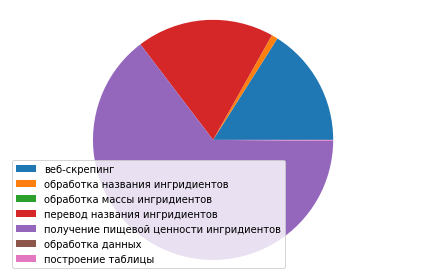

In [303]:
labels=['веб-скрепинг', 'обработка названия ингридиентов', 'обработка массы ингридиентов', 
                       'перевод названия ингридиентов', 'получение пищевой ценности ингридиентов',
                       'обработка данных', 'построение таблицы']

patches, texts = plt.pie(times_df.mean(), radius=3)

plt.legend(patches, labels, loc='best')

plt.axis('equal')
plt.tight_layout()

plt.show()

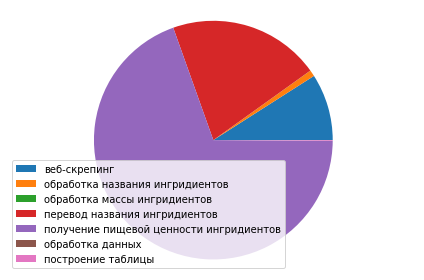

In [68]:
labels=['веб-скрепинг', 'обработка названия ингридиентов', 'обработка массы ингридиентов', 
                       'перевод названия ингридиентов', 'получение пищевой ценности ингридиентов',
                       'обработка данных', 'построение таблицы']

patches, texts = plt.pie(times, radius=3)

plt.legend(patches, labels, loc='best')

plt.axis('equal')
plt.tight_layout()

plt.show()

In [304]:
times_req = []
times_parse = []

In [306]:
for i, label in enumerate(labels):
    start_req = time.time()
    nutrients_url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={translations[i]}&pageSize=2&api_key={usda_key}'
    nutrients_response = requests.get(nutrients_url, timeout=20)
    end_req = time.time()
    times_req.append((end_req - start_req) * 1000000000)
    
    start_parse = time.time()
    nutrients_dict = nutrients_response.json()['foods'][0]['foodNutrients']
    protein = round(float(nutrients_dict[0]['value']) * amounts[i] / 100, 2)
    fat = round(float(nutrients_dict[1]['value']) * amounts[i] / 100, 2)
    carbohydrate = round(float(nutrients_dict[2]['value']) * amounts[i] / 100, 2)
    kcal = round(float(nutrients_dict[3]['value']) * amounts[i] / 100, 2)
    proteins.append(protein)
    fats.append(fat)
    carbohydrates.append(carbohydrate)
    kcals.append(kcal)
    end_parse = time.time()
    times_parse.append((end_parse - start_parse) * 1000000000)

In [321]:
tr_ds = pd.Series(times_req)
tp_ds = pd.Series(times_parse)
c = pd.concat([tr_ds, tp_ds], axis=1)
c.columns = labels
c

,запрос,обработка
0,1.976673e+09,7.624626e+05
1,8.465884e+08,1.193285e+06
2,8.132203e+08,8.995533e+05
3,6.987112e+08,1.664877e+06
4,7.653737e+08,1.596451e+06
5,6.916451e+08,1.248121e+06
6,6.646683e+08,5.252361e+05


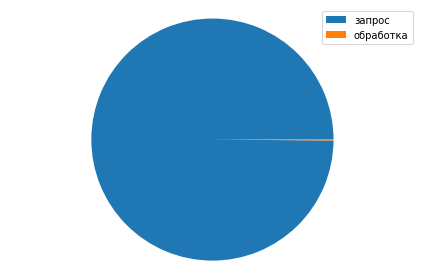

In [323]:
labels=['запрос', 'обработка']
tr_ds = pd.Series(times_req)
tp_ds = pd.Series(times_parse)
times2_df = pd.concat([tr_ds, tp_ds], axis=1)
times2_df.columns = labels

patches, texts = plt.pie(times2_df.mean(), radius=3)

plt.legend(patches, labels, loc='best')

plt.axis('equal')
plt.tight_layout()

plt.show()